### CMP637-GenAI Assignment-phase2 ## DR. Yahia
# Asmaa Qandeel Ali - 202211150
##### Jan 2026

In [1]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
from tqdm import tqdm #.notebook as tqdm
import wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Define utility functions
> I only added flattening to the data transformations

In [2]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

 ## Load and visualize the dataset
 I added image Flattening

In [3]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.13MB/s]


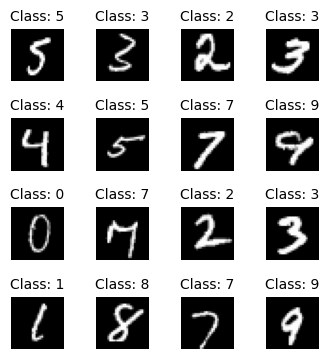

In [4]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

## Define the model

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------
#  conditional vae MODEL
# -------------------

class CVAE(nn.Module):
    def __init__(self, img_dim=28*28, num_classes=10, latent_dim=20):
        super().__init__()

        self.img_dim = img_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # ------- Encoder -------
        self.encoder = nn.Sequential(
            nn.Linear(img_dim + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )

        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

        # ------- Decoder -------
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
        )

    def encode(self, x, y):
        # concat x and one-hot y
        # print( x.shape , "!!!!!!!!!!" , y.shape)
        h = self.encoder(torch.cat([x, y], dim=1))
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        h = torch.cat([z, y], dim=1)
        x_recon = self.decoder_fc(h)
        # keep outputs in [0,1]
        return torch.sigmoid(x_recon)

    def forward(self, x, y):
        """
        x: [B, 784] in [0,1]
        y: [B, 10] one-hot
        """
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar

    @torch.no_grad()
    def sample(self, y):
        """
        y: [n_samples, 10] one-hot
        """
        n_samples = y.size(0)
        z = torch.randn(n_samples, self.latent_dim, device=y.device)
        return self.decode(z, y)


In [35]:
# identify the loss of vae based on binary cross entropy and kl divergence
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(
        recon_x, x, reduction="sum"
    )

    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (recon_loss + kl) / x.size(0)

# Instantiate model and optim
# Trainig

In [38]:

def train_cvae(model, train_loader, epochs=10, lr=1e-3):
    epoch_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
    
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
    
            # flatten images to [B, 784] from # [B, 1, 28, 28]
            # x = x.view(x.size(0), -1)
            # one-hot encode labels
            y_onehot = F.one_hot(y, num_classes=10).float()
            # move to device
            x = x.to(device)          
            y_onehot = y_onehot.to(device)
    
            optimizer.zero_grad()
    
            recon_x, mu, logvar = model(x, y_onehot)
    
            loss = vae_loss(recon_x, x, mu, logvar)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg:.4f}")
        epoch_losses.append(avg)
        # wandb.log({"epoch": epoch , "loss": avg})

    return epoch_losses



In [9]:
    # epoch_losses = []
    # for epoch in range(epochs):
    #     for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
    #         # flatten images
    #         x = x.view(x.size(0), -1).to(device)
    #         # convert labels to one-hot
    #         y_onehot = F.one_hot(y, num_classes=10).float().to(device)

    #     print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")
    #     epoch_losses.append(loss.item())
    #     wandb.log({"epoch": epoch , "loss": loss.item()})
    # return epoch_losses

In [41]:
config = {
    "hidding_dim": 512,
    "batch_size": 64,
    "epochs": 10,
    "lr": 1e-4
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

# wandb.login(key="9bf31a65f3249f4d45183b47993a4fdc3328db1f")
# wandb_logger = wandb.init(project="GenAI-Assignment-phase2", name="ebm_v1", config = config) 

loss_history = train_cvae(
    model = model,
    train_loader = train_loader,
    epochs = config["epochs"],
    lr = config["lr"]
)

Epoch 0/10: 100%|██████████| 938/938 [00:10<00:00, 87.04it/s]


Epoch [1/10] Loss: 149.5471


Epoch 1/10: 100%|██████████| 938/938 [00:11<00:00, 84.51it/s]


Epoch [2/10] Loss: 115.0332


Epoch 2/10: 100%|██████████| 938/938 [00:10<00:00, 87.25it/s]


Epoch [3/10] Loss: 108.4772


Epoch 3/10: 100%|██████████| 938/938 [00:10<00:00, 86.10it/s]


Epoch [4/10] Loss: 104.8493


Epoch 4/10: 100%|██████████| 938/938 [00:10<00:00, 86.87it/s]


Epoch [5/10] Loss: 102.6706


Epoch 5/10: 100%|██████████| 938/938 [00:10<00:00, 87.34it/s]


Epoch [6/10] Loss: 101.2207


Epoch 6/10: 100%|██████████| 938/938 [00:10<00:00, 87.26it/s]


Epoch [7/10] Loss: 100.0864


Epoch 7/10: 100%|██████████| 938/938 [00:10<00:00, 88.16it/s]


Epoch [8/10] Loss: 99.2481


Epoch 8/10: 100%|██████████| 938/938 [00:10<00:00, 88.50it/s]


Epoch [9/10] Loss: 98.4988


Epoch 9/10: 100%|██████████| 938/938 [00:10<00:00, 86.87it/s]

Epoch [10/10] Loss: 97.9701


In [18]:
# for x , y in train_loader:
#     x = x.view(x.size(0), -1)
#     # one-hot encode labels
#     y_onehot = F.one_hot(y, num_classes=10).float()
    

In [21]:
# x.shape, y.shape , y_onehot.shape

(torch.Size([32, 784]), torch.Size([32]), torch.Size([32, 10]))

In [28]:
# x2 = x.view(x.size(0), -1)
# torch.cat([x2, y_onehot], dim=1).shape

torch.Size([32, 794])

In [29]:
# x2.shape

torch.Size([32, 784])

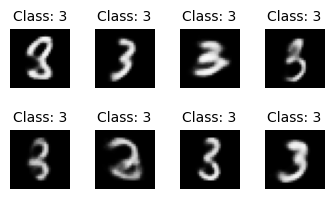

In [45]:
model.eval()

y = torch.tensor([3]*8, device=device)
y_onehot = F.one_hot(y, num_classes=10).float()

samples = model.sample(y_onehot, n_samples=8)
# shape: [8, 784]

show_images(samples, y)


In [46]:
y_onehot.shape

torch.Size([8, 10])

# Plot the loss function
for more detailed report visit my wandb report here to show all the loss and training experiments.

Well, not all, but the last working ones :-D

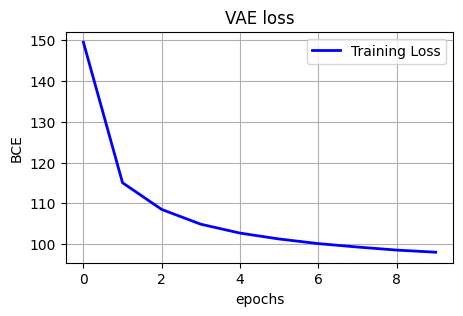

In [43]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)

plt.title('VAE loss')
plt.xlabel('epochs')
plt.ylabel('BCE')
plt.legend()
plt.grid(True)
plt.show()

## [Optional] Save and/or load the model

In [ ]:
# ## Optional TODO: Save the model if you want to store your work on disk and load it later
# torch.save(model.state_dict(), "made_temp.pth")

# loaded_model = ContinuousConditionalMADE(
#     input_size=input_dim,
#     cond_size=10,
#     hidden_sizes=hidden_dim,
# )
# # loaded_model = ConditionalMADE(input_size=input_dim,
# #                         cond_size=10,
# #                         hidden_sizes=hidden_dim,
# #                         natural_ordering=True)
# loaded_model.load_state_dict(torch.load("made_temp.pth"))

## Generate some images and display them

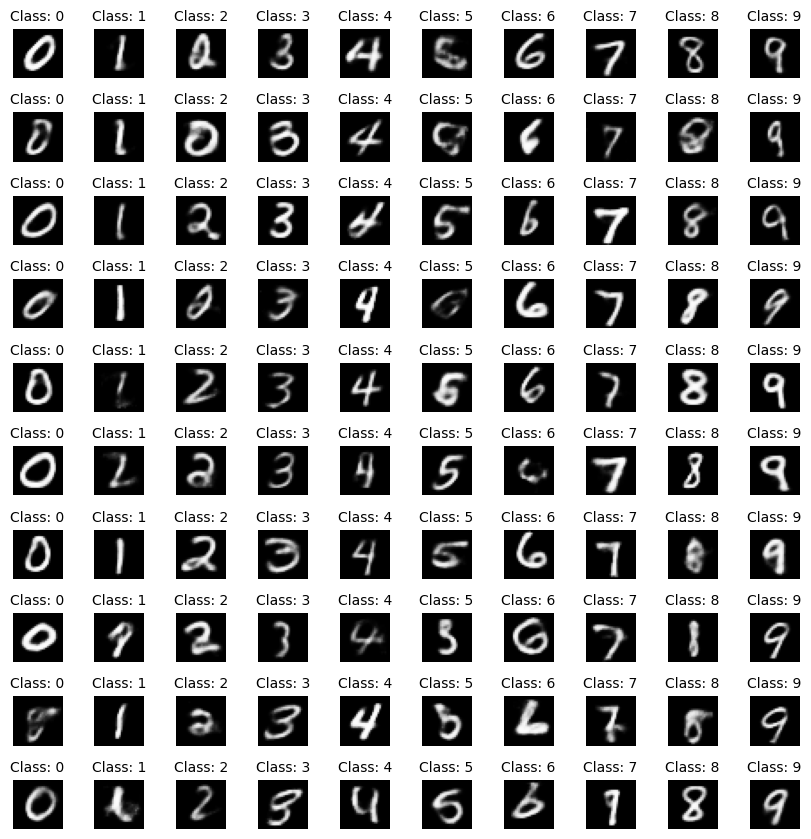

In [47]:
def generate(y: torch.Tensor) -> torch.Tensor:
    y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
    model.eval() # put model in evaluation mode
    new_x = model.sample(y_cond)
    return new_x
    
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)

x = generate(y)
show_images(x, y)

In [ ]:
# # log images in wandb
# x = x.view(x.shape[0], 1, 28, 28) # un-flatten the images
# if use_discrete_data:
#     x = x[:, 0].clamp(0,255).cpu().numpy()
#     x = np.stack([x.astype(np.uint8)]*3, axis=-1)
# else:
#     x = x[:, 0].clamp(0,1).cpu().numpy()
#     x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
    
# batch_size = x.shape[0]

# # Draw a grid or images
# wandb_image_list = []
# sample_table = wandb.Table(columns=["images", "labels"])
# for i in range(batch_size):
#     caption_text = f"Label: {y[i].item()}"
#     wandb_image = wandb.Image(x[i], caption=caption_text)
#     wandb_image_list.append(wandb_image)
    
# # 4. Log the entire list in a single wandb.log() call
# wandb.log({"Generated Samples Grid": wandb_image_list})
# wandb_logger.finish()

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).